In [10]:
using Revise
using WavePropagation
using Plots
using Printf
using FFTW
using Zygote
using Optimisers
using Statistics

In [11]:
λ = 549.02
freq = 1.011
depths = [100, 200, 300] # scintillator 90λ from metasufrace
nD = 3
F = 100

energies = [300, 800]
nE = 2

nsub = 1.4

gridL = 32 # side length (in cells) of metasurface
cell_size = 0.85 # size (in λ) of each metasurface cell

0.85

In [12]:
fn = @sprintf "%s/%s_wavcen%.3f_freq%.3f_conf%d.dat" "surdata" "tiO2" λ freq 1
model = get_model(1279, 0.11, 0.74, fn)
lb = 0.11
ub = 0.74

green = [greens(depths[iD], freq, 1., 1., gridL, cell_size) for iD in 1:nD]
kernel = [fft(green[iD]) for iD in 1:nD];

geoms = [[(0.11+0.74)/2] for i in 1:gridL, j in 1:gridL]

incident = incident_field(F, freq, nsub, gridL, cell_size)
;

In [14]:
function get_psf(geoms)
    trans = model.(geoms)
    near = incident .* trans
    #near[100:120, 100:120] .= near_before_aperture[100:120, 100:120]
    far = [convolve(near, kernel[iD]) for iD in 1:nD]
    psf = [abs.(far[iD]).^2 for iD in 1:nD]
    psf = [psf[iD] / mean(psf[iD]) for iD in 1:nD]
end

function energy_to_depths()
    [exp(-depths[iD] / energies[iE]) for iD in 1:nD, iE in 1:nE]
end

function get_xray_psf(geoms)
    psf = get_psf(geoms)
    E = energy_to_depths()
    [sum([psf[iD] .* E[iD,iE] for iD in 1:nD]) for iE in 1:nE]
end

get_xray_psf (generic function with 1 method)

In [15]:
E = energy_to_depths()

3×2 Matrix{Float64}:
 0.716531  0.882497
 0.513417  0.778801
 0.367879  0.687289

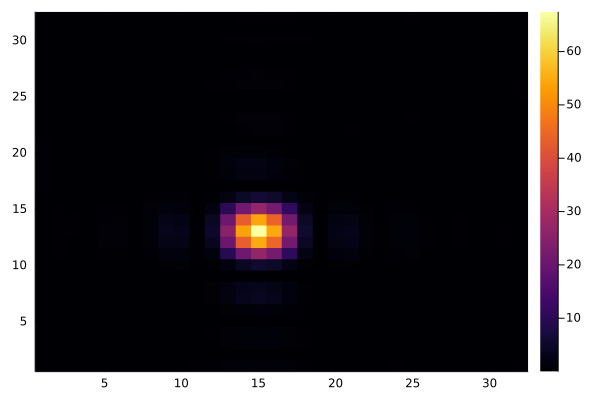

In [23]:
psf = get_psf(geoms)
# xray_psf = get_xray_psf(geoms)
heatmap(psf[1])

# psf_bin = zeros(gridL ÷ 4, gridL ÷ 4)

# for i in 1:gridL
#     for j in 1:gridL
#         psf_bin[(i-1)÷4 + 1,(j-1)÷4 + 1] += psf[1][i,j]

#     end
# end

# heatmap(psf_bin)

In [18]:
o = Optimisers.ADAM()
st = Optimisers.state(o, geoms);

In [22]:
# Optimises geoms to maximize f(geoms)

f(geoms) = get_xray_psf(geoms)[1][13,15]
#sum((get_xray_psf(geoms)[2] - get_xray_psf(geoms)[1]).^2)

for i in 1:100
    res, back = pullback(f, geoms)
    Δgeoms = back(1)[1]
    st, geoms = Optimisers.update(o, st, geoms, -Δgeoms)
    geoms = [clamp.(x, lb, ub) for x in geoms]
end

println(f(geoms))

50.233297765465444
